# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.076236,True,5.553473
1,0.060844,False,0.368952
2,-0.028633,False,-0.494726
3,-1.427719,True,5.404953
4,-0.671959,False,-1.001133
...,...,...,...
995,0.700718,True,5.251570
996,0.946380,True,7.180262
997,-0.004310,True,4.482246
998,0.618509,True,4.455502


<AxesSubplot: xlabel='v0'>

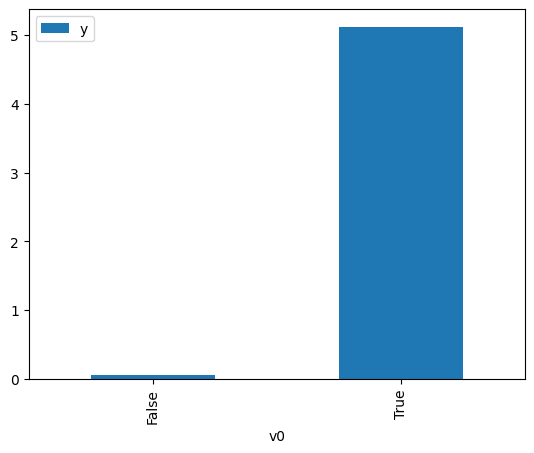

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

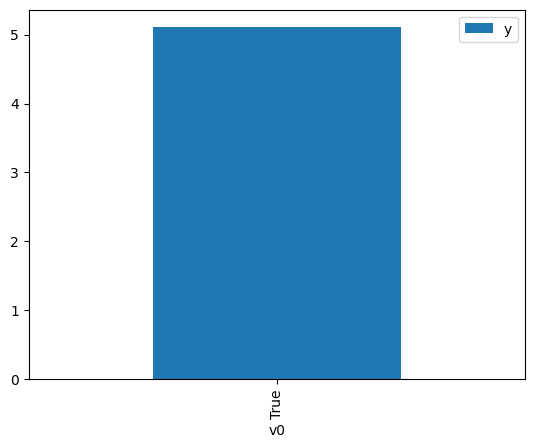

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.352919,False,0.446923,0.584806,1.709968
1,0.814069,False,0.333252,0.282563,3.539036
2,-2.343394,False,1.050524,0.925262,1.080776
3,0.828998,False,-0.382004,0.279270,3.580766
4,1.064405,False,0.701340,0.230561,4.337242
...,...,...,...,...,...
995,0.895503,False,0.163814,0.264889,3.775160
996,2.014276,False,-0.379485,0.096009,10.415706
997,-0.376085,False,-0.769199,0.590935,1.692233
998,1.836714,False,1.371098,0.114205,8.756149


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.303760,True,5.675314,0.812527,1.230728
1,1.436695,True,6.111159,0.833644,1.199553
2,0.631619,True,6.052427,0.675366,1.480680
3,0.354007,True,6.152660,0.605733,1.650893
4,-2.741986,True,2.913577,0.049674,20.131449
...,...,...,...,...,...
995,0.721921,True,5.594780,0.696601,1.435543
996,1.337709,True,3.280717,0.818109,1.222331
997,-2.741986,True,2.913577,0.049674,20.131449
998,1.812561,True,5.540571,0.883099,1.132376


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              8038.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                        0.00
Time:                        19:37:21   Log-Likelihood:                         -1410.4
No. Observations:                1000   AIC:                                      2825.
Df Residuals:                     998   BIC:                                      2835.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2405      0.036      6.761      0.000       0.171       0.310
x2             5.0122      0.048    104.315      0.000       4.918       5.106
==============================================================================
Omnibus:                        1.561   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.458   Jarque-Bera (JB):                1.428
Skew:                          -0.062   Prob(JB):                        0.490
Kurtosis:                       3.137   Cond. No.                         1.94
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""